In [517]:
from CoolProp.CoolProp import PropsSI
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from fluprodia import FluidPropertyDiagram

In [518]:
def heat_power_demand(thermal_cond, thickness, insulator_area, desired_temperature, unpowered_temperature):
    heat_transfer_coeff = thermal_cond / thickness # U = k/L
    delta_temperature = desired_temperature - unpowered_temperature
    heat_demand = heat_transfer_coeff * insulator_area * delta_temperature
    return heat_demand

thermal_cond_material = {
    "Polyurethane Foam":0.022,
    "Reinforced concrete":2.3,
    "Concrete":0.11
}

room_size = [3,2,2] # m x,y,z
outside_temp = 15 + 273.15 # C
desired_temp = -10 + 273.15 # C
wall_thickness = 15 # cm
floor_thickness = 100 # cm

walls_area = room_size[0]*room_size[2]*2 + room_size[1]*room_size[2]
floor_area = room_size[0]*room_size[1]*2
total_area = walls_area + floor_area # m^2

hpd = heat_power_demand(thermal_cond_material["Polyurethane Foam"], wall_thickness/100, total_area, desired_temp, outside_temp)
print(f"Heat power demand: {hpd} kW")

Heat power demand: -102.66666666666666 kW


Let's create a function that calculates the evaporators heat, the power and the cop:

In [519]:
def cop_and_heat_calculations(fluid, temp_2, temp_4, efficiency_compressor, heat_evap):
    s_2 = PropsSI("S", "T", temp_2, "Q", 1, fluid)
    h_2 = PropsSI("H", "T", temp_2, "Q", 1, fluid)
    press_2 = PropsSI("P", "T", temp_2, "Q", 1, fluid)
    press_4 = PropsSI("P", "T", temp_4, "Q", 0, fluid)
    press_3 = press_4 # pressure remains same after compressor / before expansion

    h_3s = PropsSI("H", "S", s_2, "P", press_3, fluid)
    h_3 = h_2 + (h_3s - h_2) / efficiency_compressor # enthalpy considering compressor efficiency

    h_4 = PropsSI("H", "T", temp_4, "Q", 0, fluid)
    h_1 = h_4 # enthalpy remains constant in expansion. refer to ph graph
    press_1 = press_2 # pressure remains constant in evaporation.

    # no calculamos s_1, s_3, s_4, t_1, t_3

    m = heat_evap / abs(h_2 - h_1) # mass flow rate kg/s. Are these enthalpies correct? or should we get h_4, h_3
    power = m * abs(h_3 - h_2) # compressor power
    cop = abs(heat_evap) / power
    heat_cond = abs(heat_evap) - power

    cop_carnot = temp_2 / abs(temp_2 - temp_4)
    efficiency_hp = cop / cop_carnot

    return m, power, cop, heat_cond, cop_carnot, efficiency_hp


Let's select some of the necessary parameters for our study:

In [520]:
# Change 'outside_temp' to hamburg.average_yearly_temp from 'climate data' class from Juan
outside_temp = 15 + 273.15 # C
desired_temp = -18 + 273.15 # C

cond_temp = outside_temp + 20
evap_temp = desired_temp - 10

evap_temp_list = np.arange(evap_temp - 10 , evap_temp + 10 , 2)
cond_temp_list = np.arange(cond_temp - 10 , cond_temp + 10 , 2)

refr_fluid = "R290" #"R134a"
efficiency_compressor = 0.8 # Efficiency assumed to be 80%
heat_evap = 2e5 # Nominal heat power (W)

Let's calculate and plot the COP for different evaporation and condensation temperatures:

Text(0.5, 1.0, 'COP vs Condensator T')

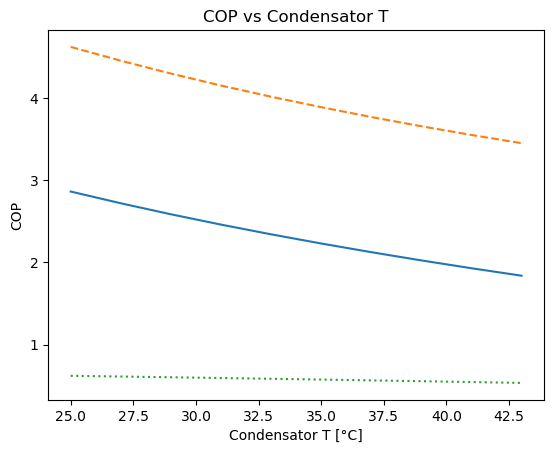

In [521]:
# Calculating COP vs Condensated Temps:
mass_sec, pow, cop, heat_condensator, cop_ca, eff_hp = cop_and_heat_calculations(
    refr_fluid, evap_temp, cond_temp_list, efficiency_compressor, heat_evap
)

# Plotting results condensator changing temps:
plt.plot(cond_temp_list - 273.15, cop, label='COP')
plt.plot(cond_temp_list - 273.15, cop_ca, label='COP carnot',linestyle='--')
plt.plot(cond_temp_list - 273.15, eff_hp, label='Eff. refrigerator',linestyle=':')
plt.xlabel('Condensator T [°C]')
plt.ylabel('COP')
plt.title('COP vs Condensator T')

Text(0.5, 1.0, 'COP vs Evaporator T')

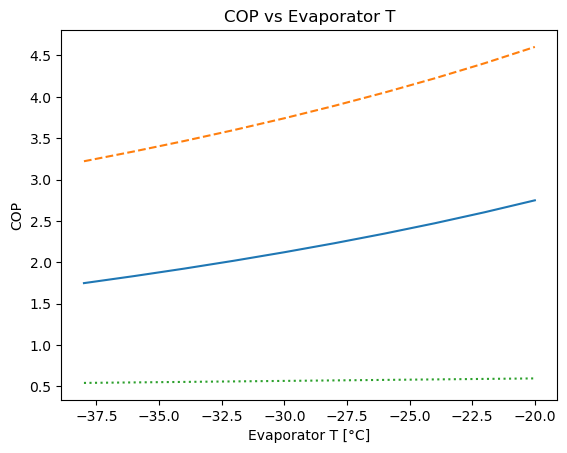

In [522]:
# Calculating COP vs Evaporator Temps:
mass_sec_ev, pow_ev, cop_ev, heat_condensator_ev, cop_ca_ev, eff_hp_ev = cop_and_heat_calculations(
    refr_fluid, evap_temp_list, cond_temp, efficiency_compressor, heat_evap
)

# Plotting results evaporator changing temps:
plt.plot(evap_temp_list - 273.15, cop_ev, label='COP')
plt.plot(evap_temp_list - 273.15, cop_ca_ev, label='COP carnot',linestyle='--')
plt.plot(evap_temp_list - 273.15, eff_hp_ev, label='Eff. refrigerator',linestyle=':')

plt.xlabel('Evaporator T [°C]')
plt.ylabel('COP')
plt.title('COP vs Evaporator T')

Now, let's plot both the condensated T° and the evaporated T° in the same 3D graph to compare results:

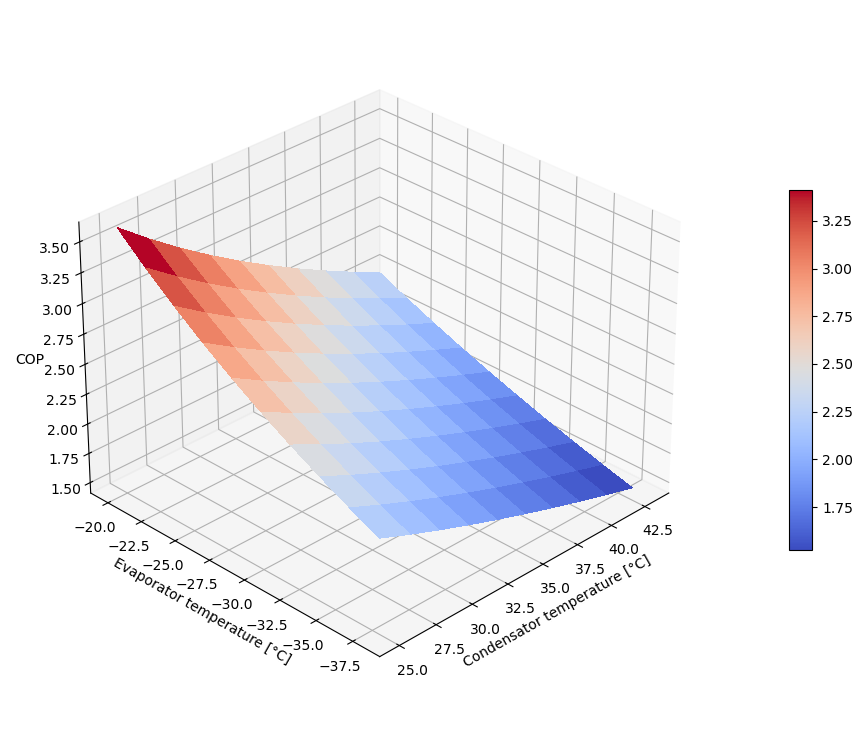

In [523]:
param_cop = pd.DataFrame(
    index=evap_temp_list, 
    columns=cond_temp_list
)

for ev_temp in evap_temp_list:
    _, _, cop, _, _, _ = cop_and_heat_calculations(
        refr_fluid, 
        ev_temp, 
        cond_temp_list, 
        efficiency_compressor, 
        heat_evap
    )
    param_cop.loc[ev_temp] = cop

param_cop

# Plot 3D Figure:
fig, ax = plt.subplots(1, figsize=(12, 7.5), subplot_kw={"projection": "3d"})

X, Y = np.meshgrid(cond_temp_list - 273.15, evap_temp_list - 273.15)

surf = ax.plot_surface(X, Y, param_cop.values, cmap=cm.coolwarm, linewidth=0, antialiased=False)

ax.set_xlabel("Condensator temperature [°C]")
ax.set_ylabel("Evaporator temperature [°C]")
ax.set_zlabel("COP")
ax.view_init(elev=30, azim=225)
ax.set_box_aspect(aspect=None, zoom=0.9)
fig.colorbar(surf, shrink=0.5, aspect=15)
plt.tight_layout()

Let's try plot the P-H Diagram:

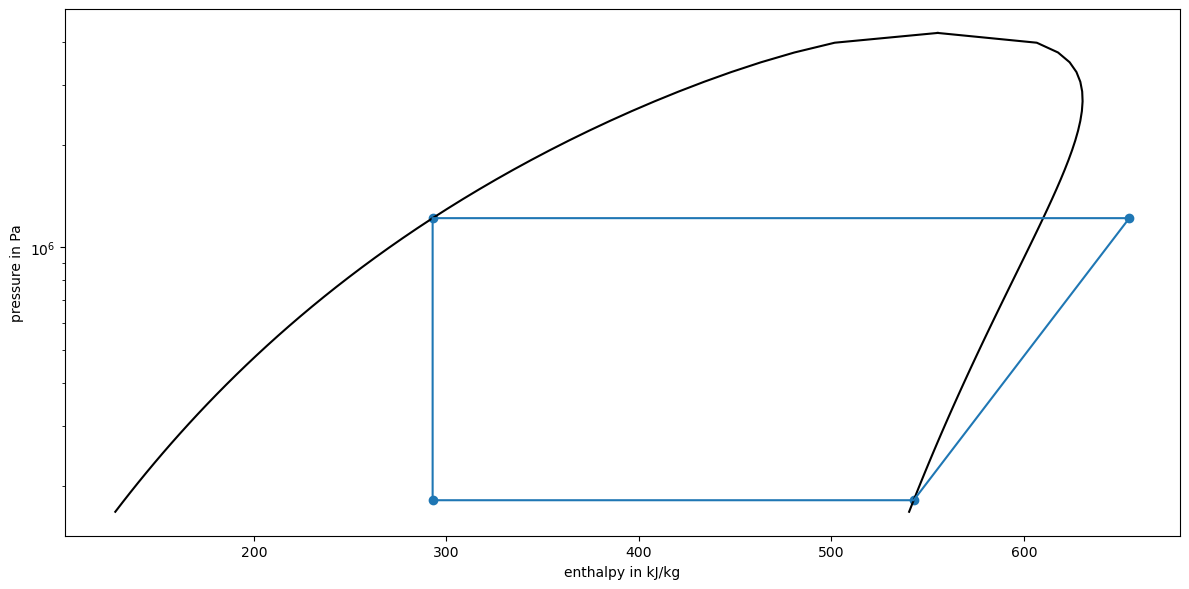

In [524]:

def press_and_enthalpy_calc(fluid, temp_2, temp_4, efficiency_compressor, heat_evap):
    s_2 = PropsSI("S", "T", temp_2, "Q", 1, fluid)
    h_2 = PropsSI("H", "T", temp_2, "Q", 1, fluid)
    press_2 = PropsSI("P", "T", temp_2, "Q", 1, fluid)
    press_4 = PropsSI("P", "T", temp_4, "Q", 0, fluid)
    press_3 = press_4 # pressure remains same after compressor / before expansion

    h_3s = PropsSI("H", "S", s_2, "P", press_3, fluid)
    h_3 = h_2 + (h_3s - h_2) / efficiency_compressor # enthalpy considering compressor efficiency

    h_4 = PropsSI("H", "T", temp_4, "Q", 0, fluid)
    h_1 = h_4 # enthalpy remains constant in expansion. refer to ph graph
    press_1 = press_2 # pressure remains constant in evaporation.

    # no calculamos s_1, s_3, s_4, t_1, t_3

    m = heat_evap / abs(h_2 - h_1) # mass flow rate kg/s. Are these enthalpies correct? or should we get h_4, h_3
    power = m * abs(h_3 - h_2) # compressor power
    cop = abs(heat_evap) / power
    heat_cond = abs(heat_evap) - power
    
    return h_1, h_2, h_3, h_4, press_1, press_2, press_3, press_4

h_1, h_2, h_3, h_4, press_1, press_2, press_3, press_4 = press_and_enthalpy_calc(
    refr_fluid, evap_temp, cond_temp, efficiency_compressor, heat_evap
)

p_range = np.geomspace(PropsSI("P", "T", 273.15 -30, "Q", 0, refr_fluid), PropsSI("PCRIT", refr_fluid))
boiling_line = PropsSI("H", "P", p_range, "Q", 0, refr_fluid) / 1e3
dew_line = PropsSI("H", "P", p_range, "Q", 1, refr_fluid) / 1e3

fig, ax = plt.subplots(1, figsize=(12, 6))

ax.set_yscale("log")
ax.plot(boiling_line, p_range, color="#000")
ax.plot(dew_line, p_range, color="#000")

ax.scatter([h / 1e3 for h in [h_1, h_2, h_3, h_4]], [press_1, press_2, press_3, press_4])
ax.plot([h / 1e3 for h in [h_1, h_2, h_3, h_4, h_1]], [press_1, press_2, press_3, press_4, press_1])

ax.set_ylabel("pressure in Pa")
ax.set_xlabel("enthalpy in kJ/kg")

_x_lims = ax.get_xlim()
_y_lims = ax.get_ylim()


plt.tight_layout()

Let's try now to plot the P-H diagram using a specialized library called 'fluprodia':

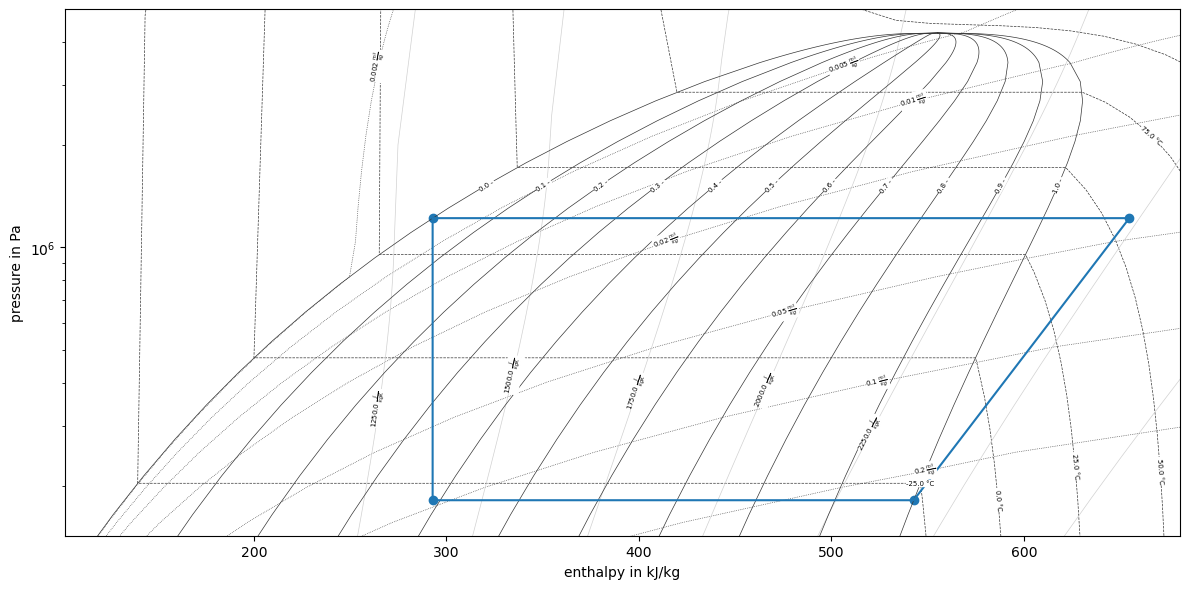

In [525]:
diagram = FluidPropertyDiagram(refr_fluid)
diagram.set_unit_system(T="°C", h="kJ/kg")
diagram.set_isolines(T=np.arange(-25, 101, 25), s=np.arange(1250, 3001, 250), h=np.arange(100, 801, 100))
diagram.calc_isolines()


fig, ax = plt.subplots(1, figsize=(12, 6))

diagram.draw_isolines(fig, ax, "logph", _x_lims[0], _x_lims[1], _y_lims[0], _y_lims[1])
#ax.scatter([h / 1e3 for h in [h_1, h_2, h_3, h_4]], [p_1, p_2, p_3, p_4])
#ax.plot([h / 1e3 for h in [h_1, h_2, h_3, h_4, h_1]], [p_1, p_2, p_3, p_4, p_1])
ax.scatter([h / 1e3 for h in [h_1, h_2, h_3, h_4]], [press_1, press_2, press_3, press_4])
ax.plot([h / 1e3 for h in [h_1, h_2, h_3, h_4, h_1]], [press_1, press_2, press_3, press_4, press_1])

ax.set_ylabel("pressure in Pa")
ax.set_xlabel("enthalpy in kJ/kg")

plt.tight_layout()

Now let's create a T-S diagram using fluprodia:

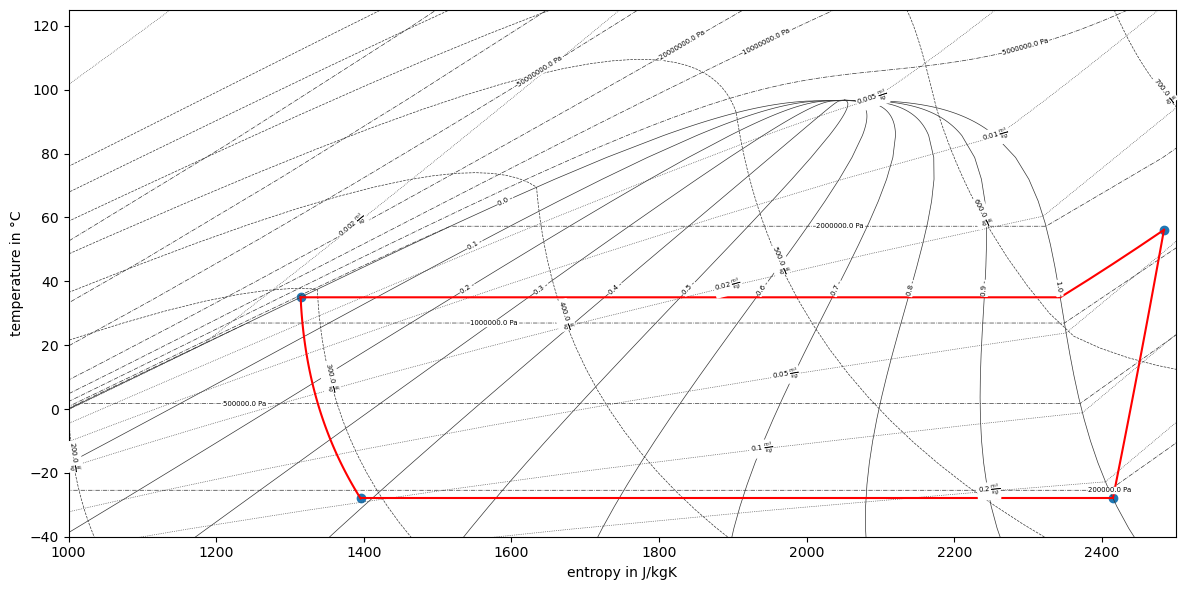

In [526]:
fig, ax = plt.subplots(1, figsize=(12, 6))

diagram.draw_isolines(fig, ax, "Ts", 1000, 2500, -40, 125)

t = []
s = []
for p, h in zip([press_1, press_2, press_3, press_4], [h_1, h_2, h_3, h_4]):
    t += [PropsSI("T", "P", p, "H", h, refr_fluid) - 273.15]
    s += [PropsSI("S", "P", p, "H", h, refr_fluid)]

ax.scatter(s, t)

lines = {
    "12": {
        "isoline_property": "p",
        "isoline_value": press_1,
        "starting_point_property": "h",
        "starting_point_value": h_1 / 1e3,
        "ending_point_property": "h",
        "ending_point_value": h_2 / 1e3
    },
    "23": {
        "isoline_property": "s",
        "isoline_value": s[1],
        "isoline_value_end": s[2],
        "starting_point_property": "p",
        "starting_point_value": press_2,
        "ending_point_property": "p",
        "ending_point_value": press_3
    },
    "34": {
        "isoline_property": "p",
        "isoline_value": press_3,
        "starting_point_property": "h",
        "starting_point_value": h_3 / 1e3,
        "ending_point_property": "h",
        "ending_point_value": h_4 / 1e3
    },
    "41": {
        "isoline_property": "h",
        "isoline_value": h_4 / 1e3,
        "starting_point_property": "p",
        "starting_point_value": press_4,
        "ending_point_property": "p",
        "ending_point_value": press_1
    },
}

for line in lines.values():
    line_data = diagram.calc_individual_isoline(**line)
    ax.plot(line_data["s"], line_data["T"], color="#FF0000")

ax.set_ylabel("temperature in °C")
ax.set_xlabel("entropy in J/kgK")
plt.tight_layout()

We have now selected a specific compressor to use, therefore compressor power is now limited ??? kW.
We would like to 